In [1]:
import tensorflow as tf
import numpy as np
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

# TensorFlow Feed-Forward Neural Network

This notebook walks through how to build a feed-forward neural network using TensorFlow. Nearly everything is the same as the NumPy implementation, except a static graph is constructed using TensorFlow. To see the process in more detail (without level-by-level encapsulation), take a look at the TensorFlow Feed-Forward Neural Network Detailed notebook.

## Layers

Instead of unrolling the network as shown in the detailed notebook, we encapsulate the common, repeated behavior into layer classes.

### Base Layer

This layer provides the virtual methods that each layer has to implement. If the layer doesn't implement the method, we default to one of these empty methods.

In [2]:
class Layer:
    """Abstract base layer for our neural network."""

The `__init__` method sets up constant information about the layer that is necessary to build the graph later. Typically, only dimensions of input/output data is required.

In [3]:
    def __init__(self):
        """Initializes layer constants necessary to construct the graph
            for training. Likely: just dimension information or nothing
            at all."""
        
Layer.__init__ = __init__

Once the information about the layer is obtained from `__init__`, we can construct any variables in the graph needed by the layer using the `build` method. In the NumPy version, this is accomplished within `__init__`. We split this operation into two because at the time of initialization, we do not have a graph defined. Without a graph, we cannot create variables.

In [4]:
    def build(self):
        """Adds any variables to the graph required by the layer. (Such
            as weight matrices.)"""
        
Layer.build = build

Each of the layers need to be connected to each other for the forward pass. This is accomplished through the `build_forward` method. Note that this is not the same as a `forward` method in the NumPy version as nothing is being computed yet. In the `build_forward` method, we are constructing operations within the graph to be executed at a later time.

In [5]:
    def build_forward(self, X):
        """Connects the layer to the previous layer through a new 
            operation in the forward pass process.
            
        Args:
            X (Tensor): A tensor representing the inputs to the layer.
                Likely: A or Z depending on the layer.
        
        Returns:
            Tensor: A tensor representing the outputs of the layer. Likely:
                Z or A depending on the layer.
                
        """

Layer.build_forward = build_forward

The layers also need to be connected to form the backward pass. We do this using the `build_backward` method. Again, this is not the same as the `backward` method as nothing is executed, only the operation is defined.

In [6]:
    def build_backward(self, dL):
        """Connects the layer to the next layer through a new operation
            in the backward pass process.
            
        Args:
            dL (Tensor): A tensor representing the gradient of the loss
                of the network with respect to the outputs of the current
                layer. Likely: dLdA or dLdZ depending on the layer.
        
        Returns:
            Tensor: A tensor representign the gradient of the loss of the
                network will respect to the inputs of the current layer.
                Likely: dLdZ or dLdA depending on the layer.
        
        """

Layer.build_backward = build_backward

Some layers need to update variables when they go through the training process. These variables are updated in the `build_sgd_step` method.

In [7]:
    def build_sgd_step(self, eta):
        """Updates trainable variables based off the results from the
            backward pass.
            
        Args:
            eta (float): The learning rate to use for the stochastic
                gradient descent update step.
        
        """

Layer.build_sgd_step = build_sgd_step

### Linear Layer

This is the simplest possible layer where all inputs are connected to all outputs.

In [8]:
class Linear(Layer):
    """Simple layer fully-connecting inputs to outputs linearly."""

To initialize this network, we just need to know the input dimensions and the output dimensions.

In [9]:
    def __init__(self, m, n):
        """Initializes the dimensions of the layer.
        
        Args:
            m (int): Number of input features to the layer.
            n (int): Number of output features of the layer.
        
        """
        self.m = m
        self.n = n
        
Linear.__init__ = __init__

With the dimensions known, we can construct the variables on the graph. Here are a few notes to consider:

- We add new variables to our graph using the `get_variable`. This the standard preferred method to introduce trainable parameters.
- Since we will likely have many of these `Linear` layers, we need to scope our variables as duplicate variable names are not allowed. By using `default_name`, TensorFlow will ensure our variable scopes are unique.
- The variables need to be initialized to some values when the graph is constructed. To tell TensorFlow what these should be initialized to later, we use `zeros_initializer` for $W_0$ and `random_normal_initializer` for $W$.
- This method assumes that the graph we wish to add the variables to is the default graph. This is only important to consider when training multiple different graphs at one time.

In [10]:
    def build(self):
        """Creates the trainable variables on the default graph for 
            the Linear layer."""
        with tf.variable_scope(name_or_scope=None, default_name='Linear'):
            
            self.W = tf.get_variable(name='W', shape=(self.m, self.n), initializer=tf.random_normal_initializer(0.0, tf.sqrt(1 / self.m)))
            self.W0 = tf.get_variable(name='W0', shape=(self.n, 1), initializer=tf.zeros_initializer)

Linear.build = build

With our variables defined, we can build the forward pass. We take the activation $A$ from the previous layer and produce the current $Z$ pre-activation.

In [11]:
    def build_forward(self, A):
        """Connects the linear layer to the previous layer by operating
            on the previous activation.
            
        Args:
            A (Tensor): An m by b tensor representing the activations from
                the previous layer with a batch of size b.
                
        Returns:
            Tensor: An n by b tensor, Z, representing the pre-activations
                as the output from this linear layer.
        
        """
        # We need this input later when computing the backward path.
        self.A = A
        
        return tf.transpose(self.W) @ self.A + self.W0
    
Linear.build_forward = build_forward

For now, we will compute the gradients by hand using back-propogation. We take the gradient of the loss with respect to the pre-activations of the layer $\partial \mathrm{Loss} / \partial Z$ and compute the gradient of the loss with respect to the activations of the previous layer $\partial \mathrm{Loss} / \partial A$. 

In addition, we save gradients of the loss with respect to the weights ($\partial \mathrm{Loss} / \partial W$ and $\partial \mathrm{Loss} / \partial W_0$) for the stochastic gradient descent update step.

In [12]:
    def build_backward(self, dLdZ):
        """Connects the next layer to the current layer using backward 
            process. Also records gradients of the loss with respect to
            weights for later stochastic gradient descent updates.
        
        Args:
            dLdZ (Tensor): An n by b tensor representing the gradient of
                the loss with respect to the current layer's 
                pre-activations for a batch of size b.
                
        Returns:
            Tensor: An m by b tensor, dLdA, representing the gradient of 
                the loss with respect to the previous layer's activations.
        
        """
        # We store these gradients for use later in the sgd_step
        self.dLdW = self.A @ tf.transpose(dLdZ)
        self.dLdW0 = tf.reduce_sum(dLdZ, axis=1, keepdims=True)

        return self.W @ dLdZ
    
Linear.build_backward = build_backward

The linear layer has some trainable parameters to update. Using the specified learning rate $\eta$, we can re-assign our variable values using stochastic gradient descent. Note that these are not executed when this method is called!Since these are isolated operations, we need to return handles to them to be executed later. To execute in parallel, we use `tf.group`.

In [13]:
    def build_sgd_step(self, eta):
        """Constructs the training update operations for the Linear layer
            weight parameters.
            
        Args:
            eta (float): The learning rate to use for the stochastic
                gradient descent update step.
        
        Returns:
            Operation: An operation that executes the stochastic gradient
                descent step for all weights.
        
        """
        return tf.group(self.W.assign_sub(eta * self.dLdW),
                        self.W0.assign_sub(eta * self.dLdW0))

Linear.build_sgd_step = build_sgd_step

### Rectified Linear Unit Activation Layer

This layer applies the relu activation function to each of the inputs element-wise.

In [14]:
class ReLU(Layer):
    """Applies relu activation function to all inputs."""

We have no variables to consider, we just need to construct the forward and backward passes. With the forward pass we compute the activation $A$ using the previous layer's pre-activation $A$.

In [15]:
    def build_forward(self, Z):
        """Connects the previous later to the current layer using the
            ReLU operation forward pass.
            
        Args:
            Z (Tensor): An m by b tensor representing the pre-activations
                from the previous layer for a batch of size b.
        
        Returns:
            Tensor: An n by b tensor, A, representing the activations from
                the current layer for a batch of size b. (Note: n and m 
                are equal.)
                
        """
        # We need this activation when computing the backward step later
        self.A = tf.maximum(0.0, Z)
        
        return self.A
    
ReLU.build_forward = build_forward

In the backward pass, we use the gradient of the loss with respect to the layer's activations $\partial \mathrm{Loss} / \partial A$ to compute the gradient of the loss with respect to the previous layer's pre-activations $\partial \mathrm{Loss} / \partial Z$.

In [16]:
    def build_backward(self, dLdA):
        """Connects the current layer to the next using the backward pass 
            process.
            
        Args:
            dLdA (Tensor): An n by b tensor representing the gradient of
                the loss with respect to the current layer's activations
                for a batch of size b.
        
        Returns:
            Tensor: An m by b tensor, dLdZ, representing the gradient of
                the loss with respect to the previous layer's activations
                for a batch of size b. (Note: n and m are equal.)
        
        """
        return tf.sign(self.A) * dLdA
    
ReLU.build_backward = build_backward

In [17]:
class Tanh(Layer):

    def build_forward(self, Z):

        self.A = tf.tanh(Z)
        return self.A
    
    def build_backward(self, dLdA):

        return (1.0 - self.A ** 2.0) * dLdA

In [18]:
class Softmax(Layer):

    def build_forward(self, Z):

        self.A = tf.exp(Z) / tf.reduce_sum(tf.exp(Z), axis=0, keepdims=True)
        return self.A
    
    def build_backward(self, dLdA):
        
        n = dLdA.shape[0].value
        
        return tf.einsum('ikj,kj->ij', tf.einsum('jk,jk,ji->ijk', self.A, 1.0 - self.A, tf.eye(n)) + tf.einsum('jk,ik,ji->ijk', -self.A, self.A, 1.0 - tf.eye(n)), dLdA)

In [19]:
class NLLM(Layer):
    
    def build_forward(self, A, Y):

        self.A = A
        self.Y = Y

        return -tf.reduce_sum(self.Y * tf.log(self.A))
    
    def build_backward(self):

        return -self.Y / self.A

In [20]:
class Accuracy(Layer):
    
    def build_forward(self, A, Y):
        
        return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(A, axis=0), tf.argmax(Y, axis=0)), tf.float32))

In [25]:
class Sequential:

    def __init__(self, layers):

        self.layers = layers
        
        # When we build layer, we need to know input and output dimensions.
        self.m = self.layers[0].m
        self.n = self.layers[0].n
        for layer in self.layers[1:]:
            self.n = getattr(layer, 'n', self.n)
        
        # This is the static graph representing our model
        self.graph = tf.Graph()
        
        # This is the runtime instance of our model
        self.sess = tf.Session(graph=self.graph)

    def build(self, eta, loss, metrics):

        # This ensures that the graph we add our variables to is the graph
        # unique to the model.
        with self.graph.as_default():
        
            self.X = tf.placeholder(name='X', shape=(self.m, None), dtype=tf.float32)
            self.Y = tf.placeholder(name='Y', shape=(self.n, None), dtype=tf.float32)

            for layer in self.layers + [loss] + metrics:
                layer.build()

            self.forward = self.build_forward(self.X)
            self.loss_forward = loss.build_forward(self.forward, self.Y)
            self.metrics_forward = tf.tuple([metric.build_forward(self.forward, self.Y) for metric in metrics])

            loss_backward = loss.build_backward()
            self.build_backward(loss_backward)

            self.build_sgd_step(eta)
            
            initializer = tf.global_variables_initializer()
        
        # This initializes the variables in our graph using the current 
        # instance session
        self.sess.run(initializer)
        
    def build_forward(self, X):
        
        self.forward = X
        for layer in self.layers:
            self.forward = layer.build_forward(self.forward)
        
        return self.forward

    def build_backward(self, dL):
        
        for layer in self.layers[::-1]:
            dL = layer.build_backward(dL)
    
    def build_sgd_step(self, eta):
        
        sgd_steps = [layer.build_sgd_step(eta) for layer in self.layers]
        self.sgd_step = tf.group(*[sgd_step for sgd_step in sgd_steps if sgd_step is not None])
    
    def sgd(self, X_train, Y_train, epochs=100):

        d, n = X_train.shape
        
        for epoch in range(epochs):

            t = np.random.randint(n)
            
            Xt = X_train[:, t:t + 1]
            Yt = Y_train[:, t:t + 1]

            self.sess.run(self.sgd_step, feed_dict={ self.X: Xt, self.Y: Yt })
            
            if epoch % 250 == 1:
                
                metrics_eval = self.sess.run(self.metrics_forward, feed_dict={ self.X: X_train, self.Y: Y_train })
                print('Iteration =', epoch, '\tAcc =', metrics_eval[1], '\tLoss =', metrics_eval[0], flush=True)

    def predict(self, X):
        
        return self.sess.run(self.forward, feed_dict={ self.X: X })

In [26]:
model = Sequential([Linear(2, 10), ReLU(),
                    Linear(10, 10), ReLU(),
                    Linear(10, 2), Softmax()])

In [27]:
X = np.array([[-0.23390341,  1.18151883, -2.46493986,  1.55322202,  1.27621763,
                2.39710997, -1.34403040, -0.46903436, -0.64673502, -1.44029872,
               -1.37537243,  1.05994811, -0.93311512,  1.02735575, -0.84138778,
               -2.22585412, -0.42591102,  1.03561105,  0.91125595, -2.26550369],
              [-0.92254932, -1.10309630, -2.41956036, -1.15509002, -1.04805327,
                0.08717325,  0.81847250, -0.75171045,  0.60664705,  0.80410947,
               -0.11600488,  1.03747218, -0.67210575,  0.99944446, -0.65559838,
               -0.40744784, -0.58367642,  1.05972780, -0.95991874, -1.41720255]])

Y = np.array([[0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
              [1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.]])

In [28]:
model.build(0.005, NLLM(), [NLLM(), Accuracy()])

In [30]:
model.sgd(X, Y, 100000)

Iteration = 1 	Acc = 0.3 	Loss = 19.753824
Iteration = 251 	Acc = 0.9 	Loss = 8.740222
Iteration = 501 	Acc = 0.9 	Loss = 6.476474
Iteration = 751 	Acc = 0.9 	Loss = 5.6205273
Iteration = 1001 	Acc = 0.9 	Loss = 5.2962203
Iteration = 1251 	Acc = 0.9 	Loss = 4.9513946
Iteration = 1501 	Acc = 0.9 	Loss = 4.7240777
Iteration = 1751 	Acc = 0.9 	Loss = 4.5196123
Iteration = 2001 	Acc = 0.9 	Loss = 4.2559686
Iteration = 2251 	Acc = 0.9 	Loss = 4.159255
Iteration = 2501 	Acc = 0.9 	Loss = 4.164777
Iteration = 2751 	Acc = 0.95 	Loss = 3.988433
Iteration = 3001 	Acc = 0.95 	Loss = 3.9109304
Iteration = 3251 	Acc = 0.9 	Loss = 3.8193903
Iteration = 3501 	Acc = 0.9 	Loss = 3.7753713
Iteration = 3751 	Acc = 0.95 	Loss = 3.7145877
Iteration = 4001 	Acc = 0.9 	Loss = 3.71833
Iteration = 4251 	Acc = 0.95 	Loss = 3.782719
Iteration = 4501 	Acc = 0.95 	Loss = 3.6218638
Iteration = 4751 	Acc = 0.9 	Loss = 3.6648734
Iteration = 5001 	Acc = 0.95 	Loss = 3.6300411
Iteration = 5251 	Acc = 0.95 	Loss = 3.576

Iteration = 43501 	Acc = 0.95 	Loss = 1.478596
Iteration = 43751 	Acc = 0.95 	Loss = 1.4386342
Iteration = 44001 	Acc = 1.0 	Loss = 1.4074268
Iteration = 44251 	Acc = 1.0 	Loss = 1.3774326
Iteration = 44501 	Acc = 1.0 	Loss = 1.3782749
Iteration = 44751 	Acc = 1.0 	Loss = 1.351286
Iteration = 45001 	Acc = 0.95 	Loss = 1.379332
Iteration = 45251 	Acc = 0.95 	Loss = 1.4688029
Iteration = 45501 	Acc = 1.0 	Loss = 1.3227298
Iteration = 45751 	Acc = 1.0 	Loss = 1.3397712
Iteration = 46001 	Acc = 0.95 	Loss = 1.3824768
Iteration = 46251 	Acc = 0.95 	Loss = 1.3363438
Iteration = 46501 	Acc = 1.0 	Loss = 1.2874571
Iteration = 46751 	Acc = 1.0 	Loss = 1.2826799
Iteration = 47001 	Acc = 0.95 	Loss = 1.2901405
Iteration = 47251 	Acc = 0.95 	Loss = 1.2910634
Iteration = 47501 	Acc = 0.95 	Loss = 1.4181383
Iteration = 47751 	Acc = 1.0 	Loss = 1.2533374
Iteration = 48001 	Acc = 1.0 	Loss = 1.2415631
Iteration = 48251 	Acc = 1.0 	Loss = 1.2417206
Iteration = 48501 	Acc = 1.0 	Loss = 1.2220026
Iterati

Iteration = 86751 	Acc = 1.0 	Loss = 0.4411411
Iteration = 87001 	Acc = 1.0 	Loss = 0.441506
Iteration = 87251 	Acc = 1.0 	Loss = 0.4428255
Iteration = 87501 	Acc = 1.0 	Loss = 0.52358294
Iteration = 87751 	Acc = 1.0 	Loss = 0.42652
Iteration = 88001 	Acc = 1.0 	Loss = 0.5184572
Iteration = 88251 	Acc = 1.0 	Loss = 0.4296863
Iteration = 88501 	Acc = 1.0 	Loss = 0.42373165
Iteration = 88751 	Acc = 1.0 	Loss = 0.5212043
Iteration = 89001 	Acc = 1.0 	Loss = 0.4576082
Iteration = 89251 	Acc = 1.0 	Loss = 0.71803844
Iteration = 89501 	Acc = 1.0 	Loss = 0.40014848
Iteration = 89751 	Acc = 1.0 	Loss = 0.40600574
Iteration = 90001 	Acc = 1.0 	Loss = 0.46285495
Iteration = 90251 	Acc = 1.0 	Loss = 0.7130199
Iteration = 90501 	Acc = 1.0 	Loss = 0.42278603
Iteration = 90751 	Acc = 1.0 	Loss = 0.3791124
Iteration = 91001 	Acc = 1.0 	Loss = 0.6275976
Iteration = 91251 	Acc = 1.0 	Loss = 0.3729471
Iteration = 91501 	Acc = 1.0 	Loss = 0.3828577
Iteration = 91751 	Acc = 1.0 	Loss = 0.57249695
Iteratio

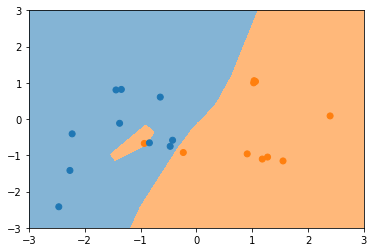

In [31]:
# Create a grid of points to classify
xx1, xx2 = np.meshgrid(np.arange(-3, 3, 0.005), np.arange(-3, 3, 0.005))

# Flatten the grid to pass into model
grid = np.c_[xx1.ravel(), xx2.ravel()].T

# Predict classification at every point on the grid
Z = model.predict(grid)[1, :].reshape(xx1.shape)

# Plot the prediction regions.
plt.imshow(Z, interpolation='bicubic', origin='lower', extent=[-3, 3, -3, 3], 
           cmap=ListedColormap(['#1f77b4', '#ff7f0e']), alpha=0.55, aspect='auto')

# Plot the original points.
_ = plt.scatter(X[0,:], X[1,:], c=Y[1,:], cmap=ListedColormap(['#1f77b4', '#ff7f0e']))